In [1]:
import os, torch
import numpy as np
from matplotlib import pyplot as plt

np.set_printoptions(precision=3, linewidth=1000)
torch.set_printoptions(precision=3, linewidth=1000)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
plt.style.use('plt_style.txt')

In [2]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn as FasterRCNN
from faster_rcnn_utils import *
from src.utils import selective_l1_loss_indexed
from src.utils import l1_loss
from src.utils import read_crop_image


frcnn = FasterRCNN(pretrained=True, box_score_thresh=0, box_detections_per_img=None).to(device)     # for raw outputs
frcnn.training = False
frcnn.eval();

def fgsm(image: torch.tensor, model: torch.nn.Module, steps: int = 5, epsilon: float = 0.1, 
        threshold: float = 0.5, loss_fn: str = 'selective', device: str = 'cuda'):
    # prep targets
    mask = torch.zeros_like(image, requires_grad=True, device=device)
    image.requires_grad = True
    criterion = selective_l1_loss_indexed if loss_fn == 'selective' else l1_loss

    for _ in range(steps):
        out = model(mask + image)[0]
        loss = criterion(out['scores'], threshold=threshold)
        model.zero_grad()
        loss.backward()

        gradient = mask.grad.data.detach()
        mask.data = mask.data - gradient * epsilon
        mask.grad.data.zero_()
        image.grad.data.zero_()

    # fix the changes
    cloacked_image = (image + mask).detach()
    return cloacked_image, abs(mask.detach())

In [3]:
orig_folder = 'data/coco/images/val2017'
pert_folder = 'C:/Users/tcilloni/Desktop/coco_cloaked'
img_fnames = [fname for fname in os.listdir(orig_folder)]
src_fnames = [f'data/coco/images/val2017/{fname}' for fname in img_fnames]

In [8]:
def make_cloak_plot(originals: List[np.ndarray], cloaks: List[np.ndarray], diffs: List[np.ndarray], nrows: int, ncols: int):
    w = 5.5 / ncols
    fig, axs = plt.subplots(nrows * 3, ncols, figsize=(ncols*w, nrows*3*w), sharey=True)

    for row in range(0, nrows*3, 3):
        for col in range(ncols):
            sample_no = (row // 3) * ncols + col
            ax_orig = axs[row + 0, col]
            ax_clkd = axs[row + 1, col]
            ax_diff = axs[row + 2, col]
            
            orig = originals[sample_no].astype(int)
            clkd = cloaks[sample_no].astype(int)
            diff = (diffs[sample_no]).astype(int)

            ax_orig.imshow(orig, vmin=0, vmax=255)
            ax_clkd.imshow(clkd, vmin=0, vmax=255)
            ax_diff.imshow(diff, vmin=0, vmax=255)

            for ax in [ax_orig, ax_clkd, ax_diff]:
                ax.axis(False)

    labels = ['Image', 'PGD Cloak', 'FA$^5$ Cloak']
    for row in range(3):
        axs[row, 0].axis(True)
        axs[row, 0].set_xticks([])
        axs[row, 0].set_yticks([])
        axs[row, 0].set_ylabel(labels[row], size=7)
        axs[row, 0].spines[:].set_linewidth(0)

    fig.subplots_adjust(wspace=0.03, hspace=0.03)
    return fig

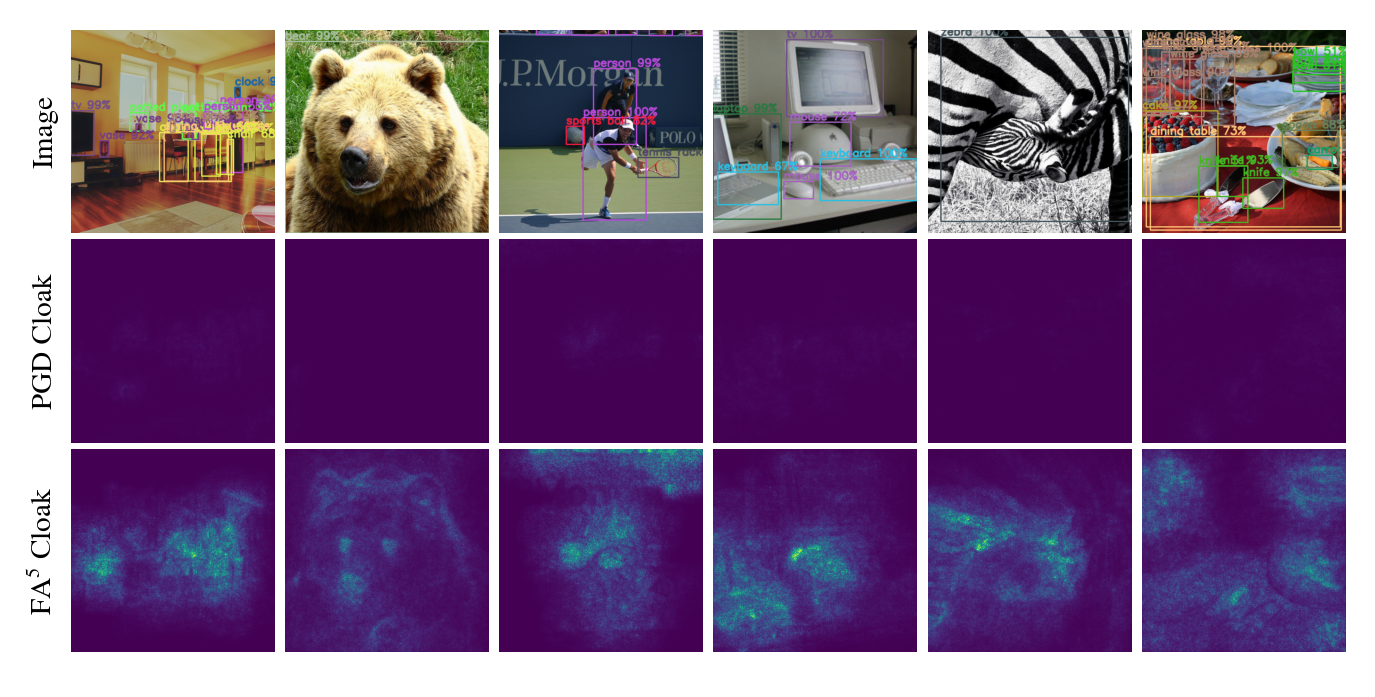

In [9]:
steps = 5
epsilon = 0.5
threshold = 0.5

images = []
annots = []
cloaks = {'l1': [], 'selective': []}

for i in [0, 1, 8, 15, 20, 25]:
    fname = src_fnames[i]
    image = read_crop_image(fname, shape=(450,450))
    annotated_image = annotate_image(image, frcnn, confidence=0.5)

    for loss_fn in ['l1', 'selective']:
        cloaked_img, cloak = fgsm(image_to_tensor(image), frcnn, steps, epsilon / steps, threshold, loss_fn=loss_fn)
        cloaked_img = image_to_numpy(cloaked_img)
        # print(loss_fn, cloak.min(), cloak.max())

        cloak = (cloak ** 0.5) * 15 
        # cloak_norm = (cloak - cloak.min()) / (cloak.max() - cloak.min())
        cloak = image_to_numpy(cloak)
        cloak = cloak.mean(axis=-1, keepdims=True)

        cloaks[loss_fn].append(cloak)
    annots.append(annotated_image)


fig = make_cloak_plot(annots, cloaks['l1'], cloaks['selective'], nrows=1, ncols=6)
fig.savefig('results/sensitive_regions.pdf', bbox_inches='tight', pad_inches=0)

## Example predictions
Lookup what to do

In [6]:
import os
from src.utils import read_crop_image
from matplotlib import pyplot as plt
plt.style.use('plt_style.txt')


epsilon = 1 / 10
attack = 'pgd'
model = 'frcnn'

orig_folder = 'data/coco/images/val2017'
pert_folder = 'C:/Users/tcilloni/Desktop/coco_cloaked'
img_fnames = [fname for fname in os.listdir(orig_folder)]
src_fnames = [f'data/coco/images/val2017/{fname}' for fname in img_fnames]

images = []
idxs = [0,1,2,3,4,5,6,7]
n = len(idxs)


# collect original images
for i in idxs:
    fname = img_fnames[i]
    orig_fname = f'{orig_folder}/{fname}'
    clk_fname1 = f'{pert_folder}/{model}_l1_{attack}_{epsilon:.3f}/images/val2017/{fname}'
    clk_fname2 = f'{pert_folder}/{model}_selective_{attack}_{epsilon:.3f}/images/val2017/{fname}'

    orig_img = read_crop_image(orig_fname, (500,500))
    clk_img1 = read_crop_image(clk_fname1, (500,500))
    clk_img2 = read_crop_image(clk_fname2, (500,500))

    images.append((orig_img, clk_img1, clk_img2))

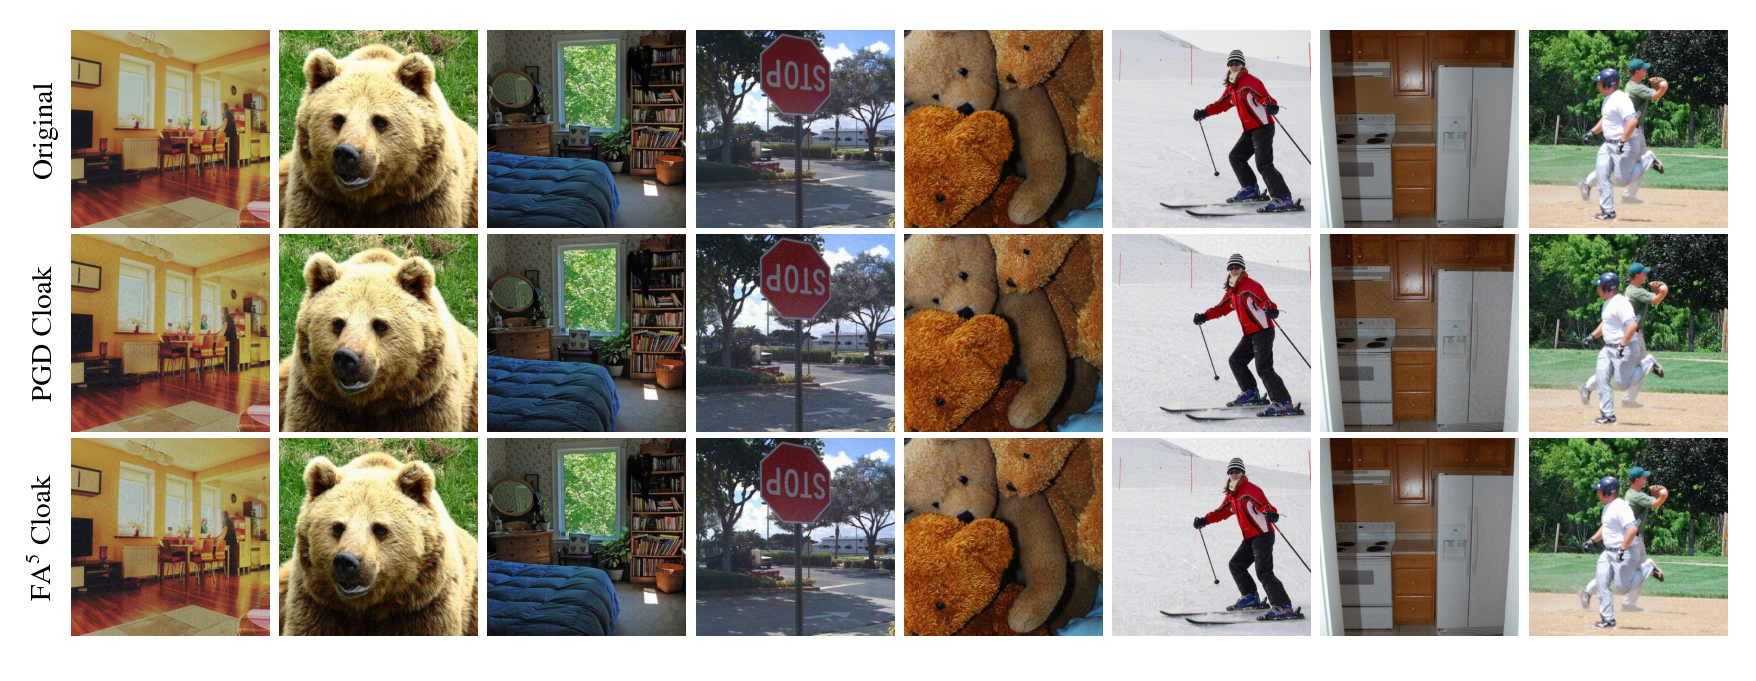

In [7]:
width = 7.14
fig, axs = plt.subplots(3, n, figsize=(width, width / n * 3), sharey=True, sharex=True)

# plot images
for i in range(len(images)):
    orig, clk1, clk2 = images[i]
    axs[0, i].imshow(orig, vmin=0, vmax=255)
    axs[1, i].imshow(clk1, vmin=0, vmax=255)
    axs[2, i].imshow(clk2, vmin=0, vmax=255)

# remove axis
for ax in axs.flatten():
    ax.axis(False)

# add labels
labels = ['Original', 'PGD Cloak', 'FA$^5$ Cloak']
for row in range(3):
    axs[row, 0].axis(True)
    axs[row, 0].set_xticks([])
    axs[row, 0].set_yticks([])
    axs[row, 0].set_ylabel(labels[row], size=7)
    axs[row, 0].spines[:].set_linewidth(0)

fig.subplots_adjust(wspace=0.03, hspace=0.03)
fig.savefig('results/samples.pdf', bbox_inches='tight', pad_inches=0)
plt.show()